In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
%matplotlib inline

**LOAD TRAIN AND TEST DATASETS**

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# directory = "gdrive/My Drive/DataCamp/Data"

# df_tr_train = pd.read_csv(''.join((directory, '/train_transaction.csv')))
# df_id_train = pd.read_csv(''.join((directory, '/train_identity.csv')))

# df_tr_test = pd.read_csv(''.join((directory, '/test_transaction.csv')))
# df_id_test = pd.read_csv(''.join((directory, '/test_identity.csv')))

df_tr_train = pd.read_csv('train_transaction.csv')
df_id_train = pd.read_csv('train_identity.csv')

df_tr_test = pd.read_csv('test_transaction.csv')
df_id_test = pd.read_csv('test_identity.csv')

In [5]:
df_train = pd.merge(df_tr_train, df_id_train, on='TransactionID', how='left')

In [6]:
del df_tr_train
del df_id_train

In [7]:
df_test = pd.merge(df_tr_test, df_id_test, on='TransactionID', how='left')

In [8]:
del df_tr_test
del df_id_test

**DATA PROCESSING**

In [9]:
df_test.columns = [col.replace('-','_') if 'id' in col else col for col in df_test.columns]

We use a threshold value such that every feature's missing values rate exceeding it are ignored 

In [10]:
thresh = 0.8
nbColtot = df_train.shape[1]
goodcols = [col for col in df_train.columns if df_train[col].isnull().sum()/df_train.shape[0]<thresh]
nbCol = len(goodcols)
print("Training set : there are {} columns out of {} with less than {}% missing values ".format(nbCol,nbColtot,thresh*100))

nbColtottest = df_test.shape[1]
goodcolstest = [col for col in df_test.columns if df_test[col].isnull().sum()/df_test.shape[0]<thresh]
nbColtest = len(goodcolstest)
print("Test set : there are {} columns out of {} with less than {}% missing values ".format(nbColtest,nbColtottest,thresh*100))


Training set : there are 360 columns out of 434 with less than 80.0% missing values 
Test set : there are 362 columns out of 433 with less than 80.0% missing values 


In [11]:
final_cols = [col for col in goodcols if col in goodcolstest]
final_cols_train = final_cols + ['isFraud']
print(final_cols)

['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91

In [12]:
train = df_train[final_cols_train]
test = df_test[final_cols]
del df_train,df_test

In [63]:
train.dtypes.value_counts()

float64    330
object      26
int64        4
dtype: int64

Identification of categorial features

In [13]:
categ = [col for col in train.columns if train[col].dtype == object]
print(categ) 

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [14]:
high_values = []
for cat in categ : 
    print(f'{cat} has {train[cat].nunique()} unique values')
    if train[cat].nunique() >= 10 :
        high_values.append(cat)

ProductCD has 5 unique values
card4 has 4 unique values
card6 has 4 unique values
P_emaildomain has 59 unique values
R_emaildomain has 60 unique values
M1 has 2 unique values
M2 has 2 unique values
M3 has 2 unique values
M4 has 3 unique values
M5 has 2 unique values
M6 has 2 unique values
M7 has 2 unique values
M8 has 2 unique values
M9 has 2 unique values
id_12 has 2 unique values
id_15 has 3 unique values
id_16 has 2 unique values
id_28 has 2 unique values
id_29 has 2 unique values
id_31 has 130 unique values
id_35 has 2 unique values
id_36 has 2 unique values
id_37 has 2 unique values
id_38 has 2 unique values
DeviceType has 2 unique values
DeviceInfo has 1786 unique values


In [66]:
train[high_values].dropna().head(10)

,P_emaildomain,R_emaildomain,id_31,DeviceInfo
10,gmail.com,gmail.com,chrome 62.0,Windows
40,gmail.com,gmail.com,chrome 62.0,Windows
48,outlook.com,outlook.com,chrome 62.0,Windows
49,anonymous.com,anonymous.com,chrome 62.0,Windows
72,outlook.com,outlook.com,chrome 62.0 for android,BLADE A602 Build/MRA58K
74,gmail.com,gmail.com,chrome 62.0,Windows
84,anonymous.com,anonymous.com,chrome 62.0,Windows
93,charter.net,charter.net,edge 15.0,Windows
99,gmail.com,gmail.com,mobile safari generic,iOS Device
105,gmail.com,gmail.com,chrome 62.0 for android,XT1635-02 Build/NPN26.118-22-2


**Handle categorial features and missing values**

To run algorithms on the datasets, we will use one hot encoding system to handle categorial variables.

For numerical features, we input the median to the missing value since median is more robust than the mean.
For categorical features, we input the mode to the missing value.

In [15]:
X_train = train.drop(columns = ['id_31', 'DeviceInfo','TransactionID'])
X_test = test.drop(columns = ['id_31', 'DeviceInfo','TransactionID'])

In [18]:
categ2 = [col for col in X_train.columns if X_train[col].dtype==object]
nocateg = [col for col in X_train.columns if col not in categ2 and col != 'isFraud']
X_train[categ2] = X_train[categ2].fillna(X_train[categ2].mode())
X_train[nocateg] = X_train[nocateg].fillna(X_train[nocateg].median())
X_test[categ2] = X_test[categ2].fillna(X_test[categ2].mode())
X_test[nocateg] = X_test[nocateg].fillna(X_test[nocateg].median())
X_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_19,id_20,id_28,id_29,id_35,id_36,id_37,id_38,DeviceType,isFraud
0,86400,68.5,W,13926,361.0,150.0,discover,142.0,credit,315.0,...,341.0,472.0,Found,Found,T,F,T,F,desktop,0
1,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,341.0,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,341.0,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,341.0,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,542.0,144.0,New,NotFound,T,F,T,T,mobile,0


In [19]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [71]:
X_train.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,M1_F,M1_T,M2_F,M2_T,M3_F,M3_T,M4_M0,M4_M1,M4_M2,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T,id_12_Found,id_12_NotFound,id_15_Found,id_15_New,id_15_Unknown,id_16_Found,id_16_NotFound,id_28_Found,id_28_New,id_29_Found,id_29_NotFound,id_35_F,id_35_T,id_36_F,id_36_T,id_37_F,id_37_T,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,NaN,111.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1


In [20]:
y_train = X_train['isFraud']
X_train.drop(columns=['isFraud'], inplace = True)

X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size=0.3)

**VANILLA RANDOM FOREST**

In [21]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train_train, y_train_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

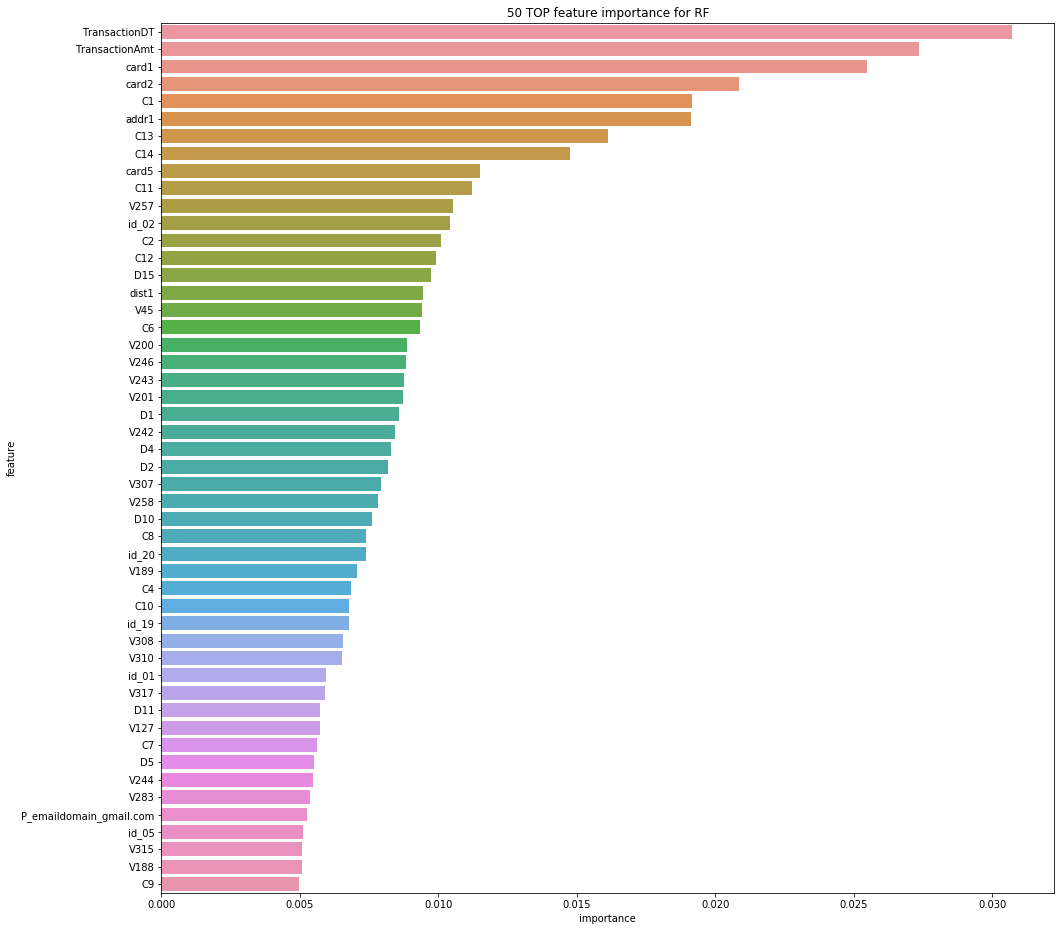

In [22]:
feature_importances = pd.DataFrame()

feature_importances['feature'] = X_train_train.columns
feature_importances['importance'] = model.feature_importances_

# feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='importance', ascending=False).head(50), x='importance', y='feature');
plt.title('50 TOP feature importance for RF')
plt.show()

In [25]:
y_pred = model.predict(X_train_test)

In [26]:
roc_auc_score(y_train_test, y_pred)

0.7195994956927985

In [27]:
confusion_matrix(y_train_test, y_pred)

array([[170901,    173],
       [  3408,   2680]], dtype=int64)

In [28]:
y_test = pd.Series(model.predict_proba(X_test)[:,1])
sub = pd.concat([test['TransactionID'],y_test], axis=1)

In [29]:
sub.columns= ['TransactionID', 'isFraud']
sub.to_csv('./subRF3.csv', index=False)

Random Forest using all data `class_weight=None`:


**Public Score 0.886511**

**Private Score 0.857021**